# Testing Convergence and $\chi^2$ in Redundant Calibration

by Aaron Parsons and Josh Dillon

Redundant calibration boils down to solving a system of equations of the form:
\begin{equation}
V_{ij} = g_i g_j^* y_b
\end{equation}
where $V_{ij}$ is a measured visibility, $g_i,g_j$ are antenna gains ('$^*$' denotes complex conjugation), and $y_b$ is a ``model visibility" shared by all visibilities that are instantaneously redundant.

In order to solve this system of equations in practice, we iteratively linearize them, solve the linearized form, and then re-linearize around the improved solution.  Approaches to linearization discussed in Liu et al. (2010) include using the logarithm (we call the solver based on this method *logcal*) and first-order Taylor expansion, e.g.:
\begin{equation}
V_{ij} - g_i g_j^* y_b = (\Delta g_i) g_j^* y_b + (\Delta g_j^*) g_i y_b + (\Delta y_b) g_i g_j^*
\end{equation}

Once the system of equations has been linearized, in can generically be written as
\begin{equation}
Ax+n = y,
\end{equation}
which has the generic solution
\begin{equation}
\hat x = (A^\dagger N^{-1}A)^{-1} A^\dagger N^{-1} y,
\end{equation}
where $N=nn^\dagger$ is the noise covariance matrix.  The explicit construction and inversion of the matrix $A^\dagger N^{-1} A$ is computationally expensive, but can be worthwhile if the result can be used repeatedly.  This is the case for *logcal*, which can use the same matrix inversion to solve measurements made at different times and frequencies.  This makes it a relatively fast way to optimize a system of equations. However, *logcal* suffers from the deficiency that noise is not Gaussian under application of the logarithm, and so the results of *logcal* are biased.

Since Taylor expansion generates coefficients in $A$ that are generally unique to each instance of a system of equations ($A$ is different across times and frequency), solution by matrix inversion is typically very expensive.  The *LinProductSolver* method implements this approach.  It has attractive properties regarding convergence and lack of bias, but is too computationally expensive to be used in any but the most restricted cases.


## How the Omnical Algorithm Works

The *omnical* algorithm is a specialization of a linear solver for redundancy-based calibration (see, e.g., Liu et al. 2010) that avoids explicitly constructing and inverting the $A^\dagger N^{-1} A$ matrix for computational efficiency.  It was devised for the work presented in Zheng et al. (2014).

The *omnical* algorithm iteratively updates the estimate of the solution (the $g$'s and $y$'s) based on the current estimated values.  Namely, the updated value for $g_i$ is constructed as
\begin{equation}
g_i^\prime = g_i \frac{\sum_j{w_{ij}\frac{V_{ij}}{g_i g_j^* y_b}}}{\sum_j{w_{ij}}},
\end{equation}
for chosen weights $w_{ij}$ assigned to each measured visibility.  Similarly,
\begin{equation}
y_b^\prime = y_b \frac{\sum_{ij}{w_{ij}\frac{V_{ij}}{g_i g_j^* y_b}}}{\sum_j{w_{ij}}}.
\end{equation}
In practice, these iterations are dampened to prevent oscillation or divergence which can result from over-pursuing a solution.  Typically, each iteration is constructed as a weighted average of the current solution and estimated next step using a weighting factor $\epsilon$ with values in the range 0.1--0.5:
\begin{align}
g_{i,{\rm next}} &= (1-\epsilon)g_i + \epsilon g_i^\prime\\
y_{b,{\rm next}} &= (1-\epsilon)y_b + \epsilon y_b^\prime\\
\end{align}

The reason this expression works can be seen by assuming $V_{ij} = g_{i,{\rm true}} g_{j,{\rm true}}^* y_{b,{\rm true}} + n_{ij}$.  For simplicity, let's assume $w_{ij}=1$, although this is just for illustrative purposes.  In this case, the equation above becomes:
\begin{align}
g_i^\prime &= \frac{g_i}{N} \sum_j{\frac{g_{i,{\rm true}} g_{j,{\rm true}} y_{b,{\rm true}} + n_{ij}}{g_i g_j^* y_b}}\\
&= \frac{1}{N} g_{i,{\rm true}} \sum_j{\frac{g_{j,{\rm true}} y_{b,{\rm true}} + n_{ij}}{g_j^* y_b}}\\
&\approx g_{i,{\rm true}} \left(1+\frac{1}{N}\sum_j{\frac{n_{ij}}{g_j^* y_b}}\right),
\end{align}
where $N$ is the number of equations involving $i$, and the final step approximates that $g_{j,{\rm true}}/g_j\approx 1$ and $y_{b,{\rm true}}/y_b\approx 1$.
This algorithm extrapolates to $g_j$ (just conjugate $V_{ij}$ to put $g_j$ out front) and $y_b$ in the same manner.

In choosing a weight for each $V_{ij}$, an optimal choice for maximum sensitivity would be to assign $w_{ij}\propto {\rm SNR}^2$, or 
\begin{equation}
w_{ij}=\frac{|g_{i,{\rm true}} g_{j,{\rm true}}^* y_{b,{\rm true}}|^2}{\langle|n_{ij}|^2\rangle}.
\end{equation}
However, we do not know the true solutions yet.  Our best option is to use our current estimate of the solution to choose the weighting, and then update the weights as we improve our estimate of the solution.

The implementation of *omnical* that currently exists in *hera_cal.redcal* makes the approximation that
\begin{equation}
w_{ij}\approx |g_i g_j^* y_b|^2 w_{ij,{\rm user}},
\end{equation}
where $g_i$, $g_j$, and $y_b$ are the current best estimates for the true parameter values, and $w_{ij,{\rm user}}$ is a user-supplied weighting for each measurement that ideally should be proportional to $|n_{ij}|^{-2}$.  These weights are used to update estimates of $g_i$, $g_j$, and $y_b$ for a series of minor-cycle iterations, and then the weights themselves are updated in a major-cycle iteration that is more computationally expensive.

# Application of Redundant Calibration Solvers

In [1]:
%matplotlib inline
from __future__ import print_function
import hera_cal.redcal as om
import hera_cal.omni
import omnical.calib
import numpy as np
import time
import uvtools
import pylab as plt
from scipy.stats import kde, chi2

In [2]:
def build_linear_array(nants, sep=14.7):
    antpos = {i: np.array([sep * i, 0, 0]) for i in range(nants)}
    return antpos

def build_hex_array(hexNum, sep=14.7):
    antpos, i = {}, 0
    for row in range(hexNum - 1, -(hexNum), -1):
        for col in range(2 * hexNum - abs(row) - 1):
            xPos = ((-(2 * hexNum - abs(row)) + 2) / 2.0 + col) * sep
            yPos = row * sep * 3**.5 / 2
            antpos[i] = np.array([xPos, yPos, 0])
            i += 1
    return antpos

In [17]:
np.random.seed(0)
SHAPE = (60,1024)
NANTS = 18
NOISE = 1e-3

antpos = build_linear_array(NANTS)
reds = om.get_reds(antpos, pols=['xx'], pol_mode='1pol')
info = om.RedundantCalibrator(reds)

gains, true_vis, d = om.sim_red_data(reds, shape=SHAPE, gain_scatter=.01)
d = {key: value.astype(np.complex64) for key,value in d.items()}
d_nos = {key: value + NOISE * om.noise(value.shape) for key,value in d.items()}
d_nos = {key: value.astype(np.complex64) for key,value in d_nos.items()}
w = dict([(k, np.float32(1.)) for k in d.keys()])
sol0 = dict([(k, np.ones_like(v)) for k, v in gains.items()])
sol0.update(info.compute_ubls(d, sol0))
sol0 = {k:v.astype(np.complex64) for k,v in sol0.items()}

In [4]:
def gen_chisq(data, sol, noise):
    d_mdl = {}
    for bls in reds:
        if len(bls) <= 1: continue
        ubl = sol[bls[0]]
        for bl in bls:
            d_mdl[(bl[0],bl[1],'xx')] = \
                sol[(bl[0],'x')] * sol[(bl[1],'x')].conj() * ubl
    res = [data[k] - v for k,v in d_mdl.items()]
    chisq = np.sum(np.abs(res)**2 / noise**2, axis=0) / (len(res) - len(sol))
    return chisq

In [55]:
def plot_gain_residuals(sol, true_gains, lim, nbins=20):
    sol_degen = info.remove_degen(antpos, sol, degen_sol=true_gains)
    keys = [k for k in sol.keys() if len(k) == 2]
    for k in keys:
        res = sol_degen[k] - true_gains[k]
        res = res.flatten()
        res = res[np.where(np.isfinite(res))]
        
        ax = plt.subplot(121)
        plt.grid()
        _ = plt.plot(res.real, res.imag, '.', alpha=.2)
        res = np.array([res.real, res.imag])
        x,y = res
        k = kde.gaussian_kde(res)
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        plt.xlabel('$\Delta$g, real')
        plt.ylabel('$\Delta$g, imag')
        plt.xlim(-lim,lim); plt.ylim(-lim,lim)
        ax.grid(b=True, which='major', color='k', linestyle='-')
        
        ax2 = plt.subplot(122, sharey=ax)
        plt.grid()
        _ = plt.contour(xi, yi, zi.reshape(xi.shape), alpha=.5)
        plt.xlabel('$\Delta$g, real')
        plt.xlim(-lim,lim)
        plt.setp(ax2.get_yticklabels(), visible=False)
        ax2.grid(b=True, which='major', color='k', linestyle='-')

## LOGCAL

In [18]:
# LOGCAL
t0 = time.time()
sol_logcal = info.logcal(d, wgts=w)
print('LOGCAL: %4.1f s' % (time.time() - t0), 
      sol_logcal.values()[0].dtype)
t0 = time.time()
sol_nos_logcal = info.logcal(d_nos, wgts=w)
print('LOGCAL: %4.1f s' % (time.time() - t0),
     sol_nos_logcal.values()[0].dtype)

LOGCAL:  2.0 s complex64
LOGCAL:  1.9 s complex64


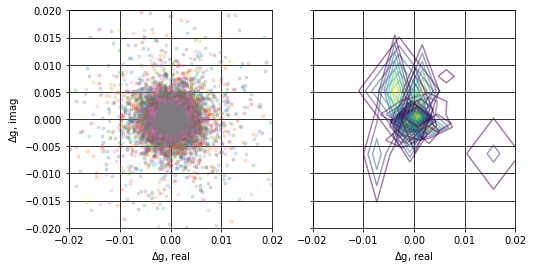

In [56]:
plt.figure(figsize=(8,4))
plot_gain_residuals(sol_nos_logcal, gains, 0.02)

This figure, which will be reproduced for each solver implementation below, illustrates the distribution of residual errors in the complex plane for estimated parameter values over 61,440 repeated solutions of the same system of equations with independent noise draws.  Color in the left panel indicates antenna index.  The right panel shows density contours for each antenna's gain parameters, with color indicating higher value contours.

By eye, *logcal*'s output appears roughly unbiased (centered around 0), but has a non-Gaussian distribution.

## OMNICAL (linsolve based)

In [22]:
# OMNICAL
t0 = time.time()
meta_omnical, sol_omnical = info.omnical(d, sol0, 
        gain=.5, maxiter=500, check_after=30, check_every=6)
print('OMNICAL: %4.1f s' % (time.time() - t0),
     sol_omnical.values()[0].dtype)
t0 = time.time()
meta_nos_omnical, sol_nos_omnical = info.omnical(d_nos, sol0, 
        gain=.5, maxiter=500, check_after=30, check_every=6)
print('OMNICAL: %4.1f s' % (time.time() - t0),
     sol_nos_omnical.values()[0].dtype)

OMNICAL: 17.4 s complex64
OMNICAL: 11.2 s complex64


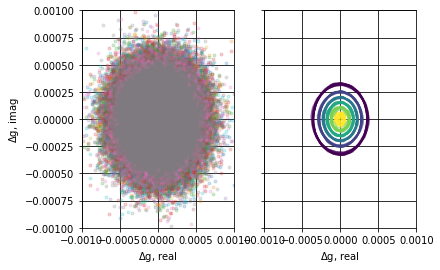

In [57]:
plt.figure()
plot_gain_residuals(sol_nos_omnical, gains, 0.001)

The figure for *linsolve*-based *omnical* shows a tighter and more Gaussian distribution of residuals relative to *logcal* above.  The contours in the right panel overlap for all antennas and are centered at zero, indicating a roughly unbiased and consistent error distribution for all antennas.

## LinProductSolver

*LinProductSolver* is the full matrix-inversion form of the Taylor-series linearization solver.  It is quite slow, so much so that to have this converge in a reasonable amount of time, I actually initialize it with a much better guess than all other solvers.  It is initialized with the converged solution from *logcal* above.

In [13]:
# LinProductSolver (only solving 1/60th of the equations)
# XXX lincal doesn't converge for dtype complex64 because of np.linalg.lstsq shenanigans
#dtype, conv_crit, mode = np.complex64, 1e-7, 'pinv'
dtype, conv_crit, mode = np.complex128, 1e-10, 'lsqr'
t0 = time.time()
_d = {k:v[:1].astype(dtype) for k,v in d.items()}
_sol = {k:v[:1].astype(dtype) for k,v in sol_logcal.items()}
meta_linsolve, sol_linsolve = \
    info.lincal(_d, _sol, maxiter=10, conv_crit=conv_crit, mode=mode)
print('LINPRODUCTSOLVER: %4.1f s' % (time.time() - t0), 
      sol_linsolve.values()[0].dtype)
t0 = time.time()
_d_nos = {k:v[:1].astype(dtype) for k,v in d_nos.items()}
_sol_nos = {k:v[:1].astype(dtype) for k,v in sol_nos_logcal.items()}
meta_nos_linsolve, sol_nos_linsolve = \
    info.lincal(_d_nos, _sol_nos, maxiter=10, conv_crit=conv_crit, mode=mode)
print('LINPRODUCTSOLVER: %4.1f s' % (time.time() - t0), 
      sol_nos_linsolve.values()[0].dtype)

LINPRODUCTSOLVER:  3.9 s complex128
LINPRODUCTSOLVER:  7.7 s complex128


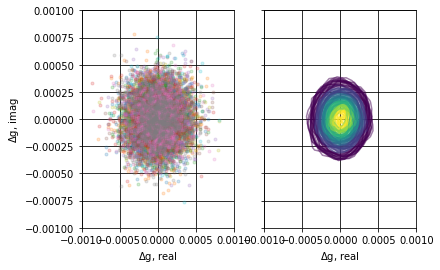

In [58]:
plt.figure()
_gains = {k:v[:1] for k,v in gains.items()}
plot_gain_residuals(sol_nos_linsolve, _gains, .001)

The figure above for *LinProductSolver*'s full *linsolve*-based matrix inversion solution looks nearly identical to the *omnical* version above.

## OMNICAL (legacy)

The legacy implementation of *omnical*, written in C and wrapped into Python, has several known shortcomings, including an apparent bias in the solutions discovered by Wenyang Li.  Nonetheless, is has been our reference implementation up to this point, so it is included here both as a performance benchmark and as a comparison for whether final solutions are biased.

In [61]:
# OMNICAL legacy
hcreds = om.get_reds(antpos, pols=['xx'], pol_mode='1pol')
pols = ['x']
antpos_ideal = np.array(antpos.values())
xs, ys, zs = antpos_ideal.T
layout = np.arange(len(xs))
_antpos = -np.ones((NANTS * len(pols), 3))
for ant, x, y in zip(layout.flatten(), xs.flatten(), ys.flatten()):
    for z, pol in enumerate(pols):
        z = 2**z  # exp ensures diff xpols aren't redundant w/ each other
        i = hera_cal.omni.Antpol(ant, pol, NANTS)
        _antpos[int(i), 0], _antpos[int(i), 1], _antpos[int(i), 2] = x, y, z
_reds = hera_cal.omni.compute_reds(NANTS, pols, _antpos[:NANTS], tol=.01)
_info = hera_cal.omni.RedundantInfo(NANTS)
_info.init_from_reds(_reds, antpos_ideal)
_d, _d_nos = {}, {}
for key in d.keys():
    if not _d.has_key(key[:2]):
        _d[key[:2]] = {}
        _d_nos[key[:2]] = {}
    _d[key[:2]][key[-1]] = d[key]
    _d_nos[key[:2]][key[-1]] = d_nos[key]
    
t0 = time.time()
meta_legacy, g, v = omnical.calib.lincal(_d, _info, maxiter=150)
print('OMNICAL: %4.1f s' % (time.time() - t0),
     g.values()[0].values()[0].dtype)

t0 = time.time()
meta_nos_legacy, g_nos, v_nos = omnical.calib.lincal(_d_nos, _info, maxiter=150)
print('OMNICAL: %4.1f s' % (time.time() - t0),
     g_nos.values()[0].values()[0].dtype)

OMNICAL: 110.5 s complex64
OMNICAL: 44.7 s complex64


In [62]:
def legacy2sol(g,v):
    sol = {}
    for i in g['x'].keys():
        sol[(i,'x')] = g['x'][i]
    for bls in _reds:
        i,j = int(bls[0][0]), int(bls[0][1])
        sol[(i,j,'xx')] = v['xx'][(i,j)]
    return sol

sol_legacy = legacy2sol(g,v)
sol_nos_legacy = legacy2sol(g_nos,v_nos)

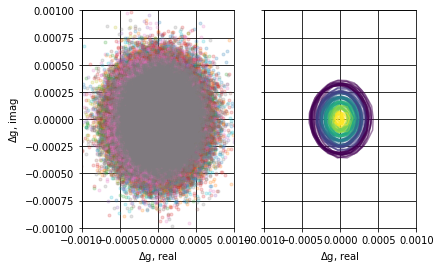

In [63]:
plt.figure()
plot_gain_residuals(sol_nos_legacy, gains, 0.001)

The residuals plotted for the legacy implementation of *omnical* look roughly consistent with *LinProductSolver* and the *linsolve*-based *omnical* version, but close examination of the right panel shows that the individual solutions for each antenna are not individually centered at zero. This is our first indication of a possible bias in the *legacy* implementation of *omnical*.

# Comparing Results

## Computing Time

$\begin{array}{lrr}
  & {\rm Noiseless} & {\rm Noisy} \\
  \hline
  {\rm logcal} & 1.9s & 1.9s \\
  {\rm omnical~(linsolve)} & 17.6s & 11.4s \\
  {\rm omnical~(legacy~C)} &  108.1s &  44.6s \\
  {\rm LinProductSolver}^\dagger & \sim250s & \sim601s \\
\end{array}$

$~$

Running from the same starting point with identical data, we have the following results.  We include the run-time of *LinProductSolver*, but mark it with $\dagger$ to indicate that it was given a better starting position than the other solvers and used double precision.  The increase in run-time in the noisy case for *LinProductSolver* is likely a result of the starting position being much worse from *logcal*, rather than being a result of the solution algorithm performing worse.

Note that the *linsolve*-based implementation of *omnical* runs faster than the C implementation because of slight algorithmic differences, including reuse of computed values between different parameter estimators and the introduction of major/minor-cycle computing cycles which allows the reuse of computed values between solver iterations.

Convergence is defined differently between the two *omnical* implementations.  For the legacy C version it was defined by the fractional change in the $\chi^2$ between iterations.  For the *linsolve* version, it is defined by the fractional change in the estimated parameter values between iterations.  In practice, it seems that the *linsolve* version more reliably converges within the maximum number of iterations.  Also, because of performance differences, the *linsolve* version can be allowed to run for more iterations, which also tends to ensure better convergence.

## Checking Convergence in $\chi^2$

For the systems of equations with noise, we can check the distribution of $\chi^2$ for the solved values.  For this idealized calibration case, convergence should result in a $\chi^2$ distribution that closely resembles the ideal analytic case.

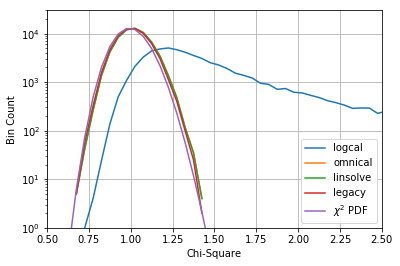

In [22]:
chisq_logcal = gen_chisq(d_nos, sol_nos_logcal, NOISE)
chisq_omnical = gen_chisq(d_nos, sol_nos_omnical, NOISE)
chisq_linsolve = gen_chisq(d_nos, sol_nos_linsolve, NOISE)
chisq_legacy = gen_chisq(d_nos, sol_nos_legacy, NOISE)

plt.figure()
for label in ['logcal','omnical','linsolve','legacy']:
    chisq = eval('chisq_' + label)
    hist,bins = np.histogram(chisq, bins=100, range=(0,5))
    _ = plt.semilogy(0.5*(bins[1:] + bins[:-1]), hist, label=label)
sol = sol_omnical
df = 2*(len(d) - len(sol))
x = 0.5*(bins[1:]+bins[:-1])
plt.plot(x, 7e5*chi2.pdf(x*df, df), label=r'$\chi^2$ PDF')
plt.grid()
plt.legend()
plt.ylim(1e0,3e4)
plt.xlim(.5,2.5)
_ = plt.xlabel('Chi-Square')
_ = plt.ylabel('Bin Count')

As we can see in the figure above, *logcal* deviates significantly from the ideal $\chi^2$ distribution.  This is expected.  The other algorithms all achieve similar $\chi^2$ distributions.  These distributions closely resemble the ideal $\chi^2$ distribution, but have a slight excess of values at higher $\chi^2$.

## Checking for Bias in Solutions

Even though an individual solution to a system of equations may be consistent with the true answer to within the noise, there may be a low-level bias that becomes visible when we average many repeated solutions together.  Here we compute $|\langle g_i-g_{i,{\rm true}}\rangle|$, the magnitude of the averaged residual deviation from the truth, and compare that to $\sqrt{\langle|g_i-g_{i,{\rm true}}|^2\rangle}/\sqrt{N}$, where $N$ is the number of measurements averaged over.  Ideally, the averaged residual deviation should integrate down in accordance with Gaussian statistics, with the result that the two values should be comparable.  If the averaged residual deviation is in excess of the expected level of fluctuations predicted by Gaussian statistics, that would be an indication of bias.

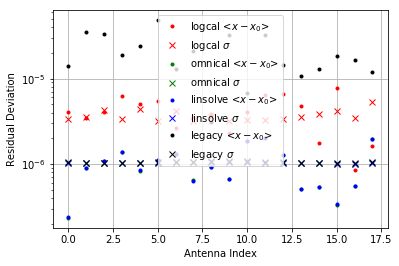

In [23]:
plt.figure()
for i,label in enumerate(['logcal','omnical','linsolve','legacy']):
    sol = eval('sol_nos_'+label)
    sol_degen = info.remove_degen(antpos, sol, degen_sol=gains)
    keys = [k for k in sol.keys() if len(k) == 2]
    res = [sol_degen[k] - gains[k] for k in keys]
    ants = [k[0] for k in keys]
    avg = [np.abs(np.average(r)) for r in res]
    err = [np.sqrt(np.average(np.abs(r)**2) / r.size) for r in res]
    color = 'rgbk'[i]
    _ = plt.semilogy(ants, avg, color+'.', label=label+' <$x-x_0$>')
    _ = plt.semilogy(ants, err, color+'x', label=label+' $\sigma$')
plt.ylabel('Residual Deviation')
plt.xlabel('Antenna Index')
plt.legend()
plt.grid()

In the figure above, we see that the expected level for residuals obeying Gaussian statistics (indicated by 'X' for each antenna) are higher for the *logcal* case, but are consistent for all the remaining cases.  This indicates the the *logcal* residuals are larger to begin with.  The actual averaged residuals (indicated by '.' for each antenna) are roughly consistent with the predicted noise level for the *logcal*, *linsolve*=*LinProductSolver*, and *omnical* cases, but not for the *legacy* C implementation of the *omnical* algorithm.  Note that the *omnical* and *linsolve* residuals match nearly exactly.

This seems to reproduce Wenyang Li's result that the legacy implementation of *omnical* is indeed biased in its final results, even though each solution is consistent with the truth to within the noise.

## Checking Noise-free Convergence

In [29]:
for i,label in enumerate(['logcal','omnical','linsolve','legacy']):
    sol = eval('sol_'+label)
    sol_degen = info.remove_degen(antpos, sol, degen_sol=gains)
    keys = [k for k in sol.keys() if len(k) == 2]
    res = [sol_degen[k] - gains[k] for k in keys]
    print(label,sol.values()[0].dtype, np.sqrt(np.average(np.abs(res)**2)))

logcal complex64 1.51592919317e-07
omnical complex64 1.87193822464e-07
linsolve complex128 8.19520014588e-09
legacy complex64 3.67838346406e-07


It seems that all the solvers can converge on the true solution in the noise-free case with better than 4e-7 precision.  The *LinProductSolver* based method does better, but remember that it was given double precision data.

## Checking Repeatability from Different Starting Points

Here we just check that the omnical solver we intend to use going forward can converge to the same solution from different starting points.

In [27]:
sols = {0:sol_nos_omnical}
for i in range(1,4):
    # Build an alternate starting point for solving
    sol1 = {k:(v + NOISE * om.noise(v.shape)).astype(np.complex64) 
            for k,v in sol0.items()}
    _, sols[i] = info.omnical(d_nos, sol1, 
            gain=.5, maxiter=500, check_after=30, check_every=6)

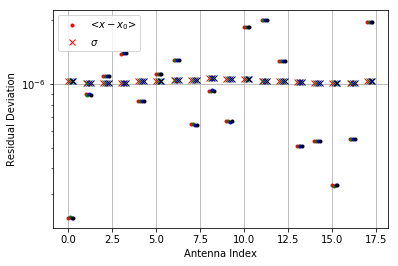

In [32]:
plt.figure()
for i in range(4):
    sol = sols[i]
    if i == 0:
        label1, label2 = '<$x-x_0$>', '$\sigma$'
    else:
        label1, label2 = '', ''
    sol_degen = info.remove_degen(antpos, sol, degen_sol=gains)
    keys = [k for k in sol.keys() if len(k) == 2]
    res = [sol_degen[k] - gains[k] for k in keys]
    ants = [k[0] for k in keys]
    avg = [np.abs(np.average(r)) for r in res]
    err = [np.sqrt(np.average(np.abs(r)**2) / r.size) for r in res]
    color = 'rgbk'[i]
    _ = plt.semilogy(np.array(ants)+.1*i, avg, color+'.', label=label1)
    _ = plt.semilogy(np.array(ants)+.1*i, err, color+'x', label=label2)
plt.ylabel('Residual Deviation')
plt.xlabel('Antenna Index')
plt.legend()
plt.grid()

So repeatability looks very good.